# Torch
## Check GPU¶

In [1]:
import torch
import sys
sys.path.append('..')
from torchlib.utils import list_device,set_device

list_device()

the rosdep view is empty: call 'sudo rosdep init' and 'rosdep update'


------------ List Devices ------------
Device 0 :
GeForce RTX 2060
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB

Device 1 :
TITAN Xp
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB



## Set torch default parameters¶

In [2]:
set_device(1)
import numpy as np
np.set_printoptions(precision = 2)
torch.set_default_dtype(torch.float32)
torch.set_printoptions(precision=4)
torch.backends.cudnn.benchmark = True
torch.set_printoptions(sci_mode=False)

Using Device 1 : TITAN Xp


# Set Arguments

In [3]:
import argparse
import sys
import os
import time
import pickle

parser = argparse.ArgumentParser()

'''Training Parameters'''
parser.add_argument('--batch_size', type=int, default=300, help='minibatch size')
parser.add_argument('--num_epochs', type=int, default=200, help='number of epochs')
parser.add_argument('--grad_clip', type=float, default=5., help='clip gradients at this value')
parser.add_argument('--learning_rate', type=float, default=0.1, help='learning rate')
parser.add_argument('--learning_rate_clip', type=float, default=0.0000001, help='learning rate clip')
parser.add_argument('--decay_rate', type=float, default=.75, help='decay rate for rmsprop')
parser.add_argument('--weight_decay', type=float, default=.0001, help='decay rate for rmsprop')
parser.add_argument('--batch_norm_decay', type=float, default=.999, help='decay rate for rmsprop')
parser.add_argument('--keep_prob', type=float, default=1.0, help='dropout keep probability')
parser.add_argument('--lamda_weights', type=float, default=.01, help='lamda weight')
parser.add_argument('--data_argumentation', type=bool, default=True, help='whether do data argument')
parser.add_argument('--is_normalization', type=bool, default=True, help='whether do data nomalization')
parser.add_argument('--target_image_size', default=[300, 300], nargs=2, type=int, help='Input images will be resized to this for data argumentation.')
parser.add_argument('--output_dim', default=3, type=int, help='output dimention.')
parser.add_argument('--feat_dim', default=128, type=int, help='feature dimention.')

'''Configure'''
parser.add_argument('--network', type=str, default='vggnet_localization')
parser.add_argument('--model_dir', type=str, default='/notebooks/global_localization/gp_gps_torch', help='rnn, gru, or lstm')

parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/2012_01_08',
                                                            '/notebooks/michigan_nn_data/2012_01_15',
                                                            '/notebooks/michigan_nn_data/2012_01_22',
                                                            '/notebooks/michigan_nn_data/2012_02_02',
                                                            '/notebooks/michigan_nn_data/2012_02_04',
                                                            '/notebooks/michigan_nn_data/2012_02_05',
                                                            '/notebooks/michigan_nn_data/2012_03_31',
                                                            '/notebooks/michigan_nn_data/2012_09_28'])
'''
#parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/test'])
parser.add_argument('--train_dataset', type=str, default = ['/notebooks/michigan_nn_data/2012_01_08'])
'''
parser.add_argument('--norm_tensor', type=str, default = ['/notebooks/global_localization/norm_mean_std.pt'])

parser.add_argument('--seed', default=1337, type=int)
parser.add_argument('--save_every', type=int, default=500, help='save frequency')
parser.add_argument('--display', type=int, default=10, help='display frequency')
parser.add_argument('--tensorboard', type=bool, default=True, help='open tensorboard')
parser.add_argument('--num_gp', type=int, default=20, help='number of local gps')

sys.argv = ['']
args = parser.parse_args()

if args.tensorboard:
    import os
    os.system('rm -rf runs/gp_gps')
    from torch.utils.tensorboard import SummaryWriter
    writer = SummaryWriter('runs/gp_gps')

# Load Dataset

In [4]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import tf.transformations as tf_tran
from tqdm import tqdm
from PIL import Image
import numpy as np
import random

#import gpflow.multioutput.kernels as mk
import gpytorch

import torch.nn as nn
import torch.optim as optim
from torchlib import resnet, vggnet
from torchlib.cnn_auxiliary import normalize, denormalize_navie, denormalize, get_relative_pose, translational_rotational_loss
from torchlib.utils import LocalizationDataset, display_loss, data2tensorboard
import time

transform = transforms.Compose([transforms.ToTensor()])
dataset = LocalizationDataset(dataset_dirs = args.train_dataset, \
                              image_size = args.target_image_size, \
                              transform = transform, get_pair = False)

if len(args.train_dataset)>7:
    [args.norm_mean, args.norm_std] = [torch.tensor(x) for x in dataset.get_norm()]
    torch.save([args.norm_mean, args.norm_std], *args.norm_tensor)
    print('Save norm and std:',*args.norm_tensor)
else:
    [args.norm_mean, args.norm_std] = torch.load(*args.norm_tensor)
    print('Load norm and std:',*args.norm_tensor)


dataloader = DataLoader(dataset, batch_size=args.batch_size, \
                        shuffle=True, num_workers=0, \
                        drop_last=True, pin_memory=True)

100%|██████████| 14037/14037 [00:28<00:00, 493.73it/s]


Save norm and std: /notebooks/global_localization/norm_mean_std.pt


# K-means

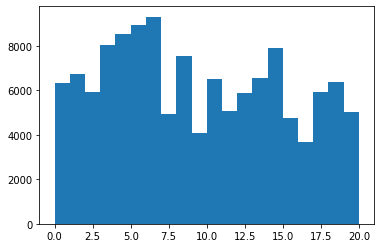

In [5]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from collections import Counter

X = np.array(dataset.Targets)[:,:2]
for i in range(20):
    np.random.seed(args.seed+i)
    mbk = MiniBatchKMeans(n_clusters = args.num_gp)
    mbk.fit(X)
    dis = Counter(mbk.labels_)
    var = np.var(np.array(list(dis.values())))/len(X)
    if var<21:
        break
if i != 20:
    plt.hist(mbk.labels_, bins = range(args.num_gp+1)) 

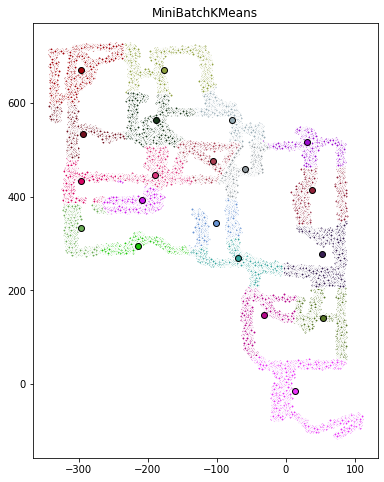

In [6]:
%matplotlib inline
from sklearn.metrics.pairwise import pairwise_distances_argmin
import random
r = lambda: random.randint(0,255)
colors = ['#%02X%02X%02X' % (r(),r(),r()) for _ in range(args.num_gp)]
fig = plt.figure(figsize=(21, 8))
#colors = ['#4EACC5', '#FF9C34', '#4E9A06']
mbk_means_cluster_centers = mbk.cluster_centers_
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)
np.save(os.path.join(args.model_dir,'k-means.npy'),mbk_means_cluster_centers)

ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(args.num_gp), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
plt.show()

# Define Model

In [7]:
class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = resnet.resnet50(pretrained=True)
    def forward(self,input_data):
        dense_feat = self.resnet(input_data)
        return dense_feat
    
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.global_context = vggnet.vggnet(input_channel=2048,opt="context")
        self.global_regressor = vggnet.vggnet(opt="regressor")
        
    def forward(self,input_data):
        context_feat = self.global_context(input_data)
        output,feature_t, feature_r = self.global_regressor(context_feat)
        return output, feature_t, feature_r

class GP(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, output_dim=3):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([output_dim])
        )
        variational_strategy = gpytorch.variational.MultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ), num_tasks=output_dim
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([output_dim]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([output_dim])),
            batch_shape=torch.Size([output_dim]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class GPNode(nn.Module):
    def __init__(self,inducing_points):
        super().__init__()
        output_dim = inducing_points.shape[0]
        feat_dim = inducing_points.shape[-1]
        assert output_dim == args.output_dim
        assert feat_dim == args.feat_dim
        
        self.gp = GP(inducing_points)
        self.likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim) 
        
    def forward(self,input_data):
        output = self.gp(input_data)
        return output
    
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = Backbone()
        self.nn = NN()
        self.gps = nn.ModuleList()
        
        self.num_gp = args.num_gp
        
        for i in range(self.num_gp):
            inducing_points = torch.zeros(args.output_dim, args.batch_size, args.feat_dim)
            gp = GPNode(inducing_points)
            self.gps.append(gp)
        
    def forward_nn(self, input_data):
        dense_feat = self.backbone(input_data)
        output, feature_t, feature_r = self.nn(dense_feat)
        rot_pred = torch.split(output, [3, 4], dim=1)[1] # 4-dimention            
        return feature_t, rot_pred
    
    def forward_gp(self,gp,trans_feat):
        trans_pred = gp(trans_feat)
        return trans_pred

In [8]:
class Trainer:
    def __init__(self,is_training=True,regressor_context_rate = [0.0,0.0]):
        self.model = Model().cuda()
        self.norm_mean = args.norm_mean.cuda()
        self.norm_std = args.norm_std.cuda()
        
        # disable learning backbone
        for param in self.model.backbone.parameters():
            param.requires_grad = False
        
        if is_training:
            # training tool
            self.optimizer = optim.Adam(self._optimize(regressor_context_rate))
            self.scheduler = optim.lr_scheduler.LambdaLR(optimizer=self.optimizer,
                                                             lr_lambda=lambda epoch: args.decay_rate**epoch)
        else:
            # disable all learning
            for param in self.model.parameters():
                param.requires_grad = False
        
    def load_model(self, file_name = 'pretrained.pth'):
        # load file info
        state_dict = torch.load(os.path.join(args.model_dir, file_name))
        if 'net.resnet.conv1.weight' in state_dict:
            print('Transform from old model.')
            # Part 1: backbone
            backbone_state_dict = self._from_old_model(state_dict,'backbone')
            print('Backbone parameters layer:',len(backbone_state_dict.keys()))
            self.model.backbone.load_state_dict(backbone_state_dict,strict = True)
            # Part 2: nn
            nn_state_dict = self._from_old_model(torch.load(os.path.join(args.model_dir, file_name)),'nn')
            print('NN parameters layer:',len(nn_state_dict.keys()))
            self.model.nn.load_state_dict(nn_state_dict,strict = True)
        else:
            print('Parameters layer:',len(state_dict.keys()))
            # load file to model
            self.model.load_state_dict(state_dict,strict = True)
        print('Model Structure:')
        # Display model structure
        for name, param in self.model.named_parameters():
            print(name, param.shape)
        print('Parameters layer:',len(self.model.state_dict().keys()))
    
    def _from_old_model(self, state_dict, select = 'backbone'):
        if select == 'backbone':
            for key in list(state_dict):
                if 'net.resnet.' in key:
                    state_dict[key.replace('net.resnet.','resnet.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        elif select == 'nn':
            for key in list(state_dict):
                if 'net.global_regressor.' in key:
                    state_dict[key.replace('net.global_regressor.','global_regressor.')] = state_dict.pop(key)
                elif 'net.global_context.' in key:
                    state_dict[key.replace('net.global_context.','global_context.')] = state_dict.pop(key)
                else:
                    state_dict.pop(key)
        return state_dict
    
    def save_model(self, file_name = 'model-{}-{}.pth'):
        checkpoint_path = os.path.join(args.model_dir, file_name)
        torch.save(self.model.state_dict(),checkpoint_path)
        print('Saving model to ' +  file_name)
        
    def _optimize(self,regressor_context_rate = [0.0,0.0]):
        optimizer = [
                {'params': self.model.gps.parameters(), \
                 'lr': args.learning_rate,'weight_decay':args.weight_decay}]
            
        if regressor_context_rate[0]!=0:
            optimizer += [{'params': self.model.nn.global_regressor.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[0],'weight_decay':args.weight_decay}]
            print('Regressor learn rate:',regressor_context_rate[0])
        else:
            for param in self.model.nn.global_regressor.parameters():
                param.requires_grad = False
                
        if regressor_context_rate[1]!=0:
            optimizer += [{'params': self.model.nn.global_context.parameters(), \
                 'lr': args.learning_rate * regressor_context_rate[1],'weight_decay':args.weight_decay}]
            print('Context learn rate:',regressor_context_rate[1])
        else:
            for param in self.model.nn.global_context.parameters():
                param.requires_grad = False
                
        return optimizer
            
    def train(self,x,y):
        # Step 0: zero grad
        self.optimizer.zero_grad()
        
        start = time.time()
        # Step 1: get data
        #labels = torch.from_numpy(pairwise_distances_argmin(y[:,:2].numpy(), mbk_means_cluster_centers)).cuda()
        labels = pairwise_distances_argmin(y[:,:2].numpy(), mbk_means_cluster_centers)
        x,y = x.cuda(),y.cuda()
        
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std)
            
        # Step 2: training
        assert self.model.training == True
        
        trans_loss = torch.tensor(0.).cuda()
        
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        trans_feat, rot_pred = self.model.forward_nn(x)
        rot_loss = self._nn_loss(rot_pred,rot_target)
        
        gps_loss = np.zeros(args.num_gp)
        for i,gp in enumerate(self.model.gps):
            num_data = dis[i]
            label_mask = labels == i
            sub_x = trans_feat[label_mask]
            sub_y = trans_target[label_mask]
            if sub_y.shape[0]>0:
                gp_loss = self._gp_loss(gp,num_data,sub_x,sub_y)
                gps_loss[i] = float(gp_loss)
                trans_loss += gp_loss
        trans_loss = trans_loss/self.model.num_gp
        total_loss = trans_loss + args.lamda_weights * rot_loss
        
        #Step 3: update
        total_loss.backward()
        self.optimizer.step()
        
        batch_time = time.time() - start
        return float(total_loss), batch_time, gps_loss
    
    def _nn_loss(self,rot_pred,rot_target):
        rot_loss = 1. - torch.mean(torch.square(torch.sum(torch.mul(rot_pred,rot_target),dim=1)))
        return rot_loss
        
    def _gp_loss(self,gp,num_data,trans_feat,trans_target):
        # predict
        trans_pred = self.model.forward_gp(gp,trans_feat)
        mll = gpytorch.mlls.PredictiveLogLikelihood(gp.likelihood, gp.gp, num_data = num_data)
        
        # trans loss
        trans_loss = -1.*mll(trans_pred, trans_target)
        
        return trans_loss
    
    def _eval_gp(self, gp, trans_pred):
        c_mean, c_var = trans_pred.mean, trans_pred.variance
        y_mean, y_var = gp.likelihood(trans_pred).mean, gp.likelihood(trans_pred).variance
        
        return y_mean, c_mean, c_var
    
    def _sample(self, mean, var, num_sample = 100):
        dist = Normal(mean, var)
        samples = dist.sample([num_sample])
        return samples

    def eval_forward(self,x,y,num_sample = 100,output_denormalize = True):
        # Step 1: get data
        labels = pairwise_distances_argmin(y[:,:2].numpy(), mbk_means_cluster_centers)
        x,y = x.cuda(),y.cuda()
        if args.is_normalization:
            y = normalize(y,self.norm_mean, self.norm_std)
        
        # Step 2: forward
        assert self.model.training == False
        trans_feat, rot_pred = self.model.forward_nn(x)
        
        trans_pred = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_mean = torch.zeros(y.shape[0],args.output_dim).cuda()
        trans_var = torch.zeros(y.shape[0],args.output_dim).cuda()

        for i,gp in enumerate(trainer.model.gps):
            label_mask = labels == i
            sub_x = trans_feat[label_mask]
            if sub_x.shape[0]>0:
                sub_trans_pred = self.model.forward_gp(gp,sub_x)
                sub_trans_pred, sub_trans_mean, sub_trans_var = self._eval_gp(gp, sub_trans_pred)
                trans_pred[label_mask] = sub_trans_pred
                trans_mean[label_mask] = sub_trans_mean
                trans_var[label_mask] = sub_trans_var
        
        if args.is_normalization and output_denormalize:
            trans_pred = denormalize_navie(trans_pred, self.norm_mean, self.norm_std)
            trans_mean = denormalize_navie(trans_mean, self.norm_mean, self.norm_std)
            trans_var = trans_var.mul(self.norm_std)
            y = denormalize(y, self.norm_mean, self.norm_std)
        
        samples = self._sample(trans_mean, trans_var, num_sample)
        
        # Step 3: split output
        trans_target, rot_target = torch.split(y, [3, 4], dim=1)
        
        return trans_pred, rot_pred, trans_target, rot_target, samples

trainer = Trainer(regressor_context_rate = [0.,0.])
#trainer = Trainer(regressor_context_rate = [0.1,0.01])

trainer.load_model('pretrained_old.pth')
#trainer.load_model('pretrained_gp30.pth')

Transform from old model.
Backbone parameters layer: 318
NN parameters layer: 28
Model Structure:
backbone.resnet.conv1.weight torch.Size([64, 1, 7, 7])
backbone.resnet.bn1.weight torch.Size([64])
backbone.resnet.bn1.bias torch.Size([64])
backbone.resnet.layer1.0.conv1.weight torch.Size([64, 64, 1, 1])
backbone.resnet.layer1.0.bn1.weight torch.Size([64])
backbone.resnet.layer1.0.bn1.bias torch.Size([64])
backbone.resnet.layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
backbone.resnet.layer1.0.bn2.weight torch.Size([64])
backbone.resnet.layer1.0.bn2.bias torch.Size([64])
backbone.resnet.layer1.0.conv3.weight torch.Size([256, 64, 1, 1])
backbone.resnet.layer1.0.bn3.weight torch.Size([256])
backbone.resnet.layer1.0.bn3.bias torch.Size([256])
backbone.resnet.layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1])
backbone.resnet.layer1.0.downsample.1.weight torch.Size([256])
backbone.resnet.layer1.0.downsample.1.bias torch.Size([256])
backbone.resnet.layer1.1.conv1.weight torch.Size([64, 

In [9]:
for name, param in trainer.model.named_parameters():
    if param.requires_grad:
        print (name, param.shape)

gps.0.gp.variational_strategy.base_variational_strategy.inducing_points torch.Size([3, 300, 128])
gps.0.gp.variational_strategy.base_variational_strategy._variational_distribution.variational_mean torch.Size([3, 300])
gps.0.gp.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar torch.Size([3, 300, 300])
gps.0.gp.mean_module.constant torch.Size([3, 1])
gps.0.gp.covar_module.raw_outputscale torch.Size([3])
gps.0.gp.covar_module.base_kernel.raw_lengthscale torch.Size([3, 1, 1])
gps.0.likelihood.raw_noise torch.Size([1])
gps.0.likelihood.noise_covar.raw_noise torch.Size([3])
gps.1.gp.variational_strategy.base_variational_strategy.inducing_points torch.Size([3, 300, 128])
gps.1.gp.variational_strategy.base_variational_strategy._variational_distribution.variational_mean torch.Size([3, 300])
gps.1.gp.variational_strategy.base_variational_strategy._variational_distribution.chol_variational_covar torch.Size([3, 300, 300])
gps.1.gp.mean_module.constant

# Training

## Training Epoch

In [10]:
trainer.model.train()
for e in range(args.num_epochs):
#for e in range(1):
    train_loss = 0.
    for b, data in enumerate(dataloader, 0):
        x,y = data.values()
        
        single_loss, batch_time, gps_loss = trainer.train(x,y)
        
        with torch.no_grad():
            train_loss += single_loss
            if args.tensorboard:
                data2tensorboard(writer,single_loss,train_loss/(b+1),e*len(dataloader)+(b+1))
                writer.add_scalars('gps_loss',
                   {'gp'+str(i):gps_loss[i] for i in range(args.num_gp) if gps_loss[i] != 0},
                   e*len(dataloader)+(b+1))
            if ((b+1)%args.display == 0):
                display_loss(e*len(dataloader)+(b+1),args.num_epochs*len(dataloader),e,
                              train_loss/(b+1),batch_time,trainer.scheduler.get_last_lr()[0])          
            if (e * len(dataloader) + (b+1)) % args.save_every == 0:
                trainer.save_model('model-{}-{}.pth'.format(e, e * len(dataloader) + (b+1)))
            if trainer.scheduler.get_last_lr()[0] > args.learning_rate_clip and (e * len(dataloader) + (b+1)) % 200 == 0:
                trainer.scheduler.step()

10/85400 (epoch 0), train_loss = 3.60290873, time/batch = 1.292, learning rate = 0.10000000
20/85400 (epoch 0), train_loss = 2.74672922, time/batch = 1.296, learning rate = 0.10000000
30/85400 (epoch 0), train_loss = 1.92104980, time/batch = 1.295, learning rate = 0.10000000
40/85400 (epoch 0), train_loss = 1.20780340, time/batch = 1.304, learning rate = 0.10000000
50/85400 (epoch 0), train_loss = 0.64259346, time/batch = 1.304, learning rate = 0.10000000
60/85400 (epoch 0), train_loss = 0.23849093, time/batch = 1.302, learning rate = 0.10000000
70/85400 (epoch 0), train_loss = -0.03224901, time/batch = 1.313, learning rate = 0.10000000
80/85400 (epoch 0), train_loss = -0.24615546, time/batch = 1.306, learning rate = 0.10000000
90/85400 (epoch 0), train_loss = -0.42737917, time/batch = 1.310, learning rate = 0.10000000
100/85400 (epoch 0), train_loss = -0.58110338, time/batch = 1.304, learning rate = 0.10000000
110/85400 (epoch 0), train_loss = -0.70538337, time/batch = 1.302, learning

894/85400 (epoch 2), train_loss = -4.86956195, time/batch = 1.323, learning rate = 0.03164062
904/85400 (epoch 2), train_loss = -4.89494643, time/batch = 1.322, learning rate = 0.03164062
914/85400 (epoch 2), train_loss = -4.90810072, time/batch = 1.321, learning rate = 0.03164062
924/85400 (epoch 2), train_loss = -4.91878445, time/batch = 1.313, learning rate = 0.03164062
934/85400 (epoch 2), train_loss = -4.93406439, time/batch = 1.326, learning rate = 0.03164062
944/85400 (epoch 2), train_loss = -4.96477698, time/batch = 1.323, learning rate = 0.03164062
954/85400 (epoch 2), train_loss = -4.96751006, time/batch = 1.325, learning rate = 0.03164062
964/85400 (epoch 2), train_loss = -4.97445404, time/batch = 1.325, learning rate = 0.03164062
974/85400 (epoch 2), train_loss = -4.98904994, time/batch = 1.329, learning rate = 0.03164062
984/85400 (epoch 2), train_loss = -5.00102344, time/batch = 1.320, learning rate = 0.03164062
994/85400 (epoch 2), train_loss = -5.00962415, time/batch = 

1768/85400 (epoch 4), train_loss = -8.04281803, time/batch = 1.316, learning rate = 0.01001129
1778/85400 (epoch 4), train_loss = -8.04538845, time/batch = 1.325, learning rate = 0.01001129
1788/85400 (epoch 4), train_loss = -8.05592225, time/batch = 1.327, learning rate = 0.01001129
1798/85400 (epoch 4), train_loss = -8.06393593, time/batch = 1.317, learning rate = 0.01001129
1808/85400 (epoch 4), train_loss = -8.06528467, time/batch = 1.324, learning rate = 0.00750847
1818/85400 (epoch 4), train_loss = -8.07119630, time/batch = 1.329, learning rate = 0.00750847
1828/85400 (epoch 4), train_loss = -8.08150137, time/batch = 1.321, learning rate = 0.00750847
1838/85400 (epoch 4), train_loss = -8.09038810, time/batch = 1.314, learning rate = 0.00750847
1848/85400 (epoch 4), train_loss = -8.09579264, time/batch = 1.332, learning rate = 0.00750847
1858/85400 (epoch 4), train_loss = -8.09614812, time/batch = 1.328, learning rate = 0.00750847
1868/85400 (epoch 4), train_loss = -8.10090401, ti

2642/85400 (epoch 6), train_loss = -8.48666468, time/batch = 1.323, learning rate = 0.00237573
2652/85400 (epoch 6), train_loss = -8.48901798, time/batch = 1.324, learning rate = 0.00237573
2662/85400 (epoch 6), train_loss = -8.48996737, time/batch = 1.326, learning rate = 0.00237573
2672/85400 (epoch 6), train_loss = -8.49291107, time/batch = 1.322, learning rate = 0.00237573
2682/85400 (epoch 6), train_loss = -8.49556034, time/batch = 1.321, learning rate = 0.00237573
2692/85400 (epoch 6), train_loss = -8.49561583, time/batch = 1.319, learning rate = 0.00237573
2702/85400 (epoch 6), train_loss = -8.49461420, time/batch = 1.310, learning rate = 0.00237573
2712/85400 (epoch 6), train_loss = -8.49462419, time/batch = 1.325, learning rate = 0.00237573
2722/85400 (epoch 6), train_loss = -8.49661918, time/batch = 1.315, learning rate = 0.00237573
2732/85400 (epoch 6), train_loss = -8.49816058, time/batch = 1.311, learning rate = 0.00237573
2742/85400 (epoch 6), train_loss = -8.49985436, ti

3516/85400 (epoch 8), train_loss = -8.57663486, time/batch = 1.323, learning rate = 0.00075169
3526/85400 (epoch 8), train_loss = -8.57602290, time/batch = 1.318, learning rate = 0.00075169
3536/85400 (epoch 8), train_loss = -8.57521274, time/batch = 1.313, learning rate = 0.00075169
3546/85400 (epoch 8), train_loss = -8.57151403, time/batch = 1.318, learning rate = 0.00075169
3556/85400 (epoch 8), train_loss = -8.57126171, time/batch = 1.327, learning rate = 0.00075169
3566/85400 (epoch 8), train_loss = -8.57228198, time/batch = 1.312, learning rate = 0.00075169
3576/85400 (epoch 8), train_loss = -8.57276850, time/batch = 1.313, learning rate = 0.00075169
3586/85400 (epoch 8), train_loss = -8.57267193, time/batch = 1.325, learning rate = 0.00075169
3596/85400 (epoch 8), train_loss = -8.57239628, time/batch = 1.334, learning rate = 0.00075169
3606/85400 (epoch 8), train_loss = -8.57158631, time/batch = 1.330, learning rate = 0.00056377
3616/85400 (epoch 8), train_loss = -8.57200223, ti

4390/85400 (epoch 10), train_loss = -8.59860463, time/batch = 1.328, learning rate = 0.00023784
4400/85400 (epoch 10), train_loss = -8.60071818, time/batch = 1.321, learning rate = 0.00023784
4410/85400 (epoch 10), train_loss = -8.60089812, time/batch = 1.312, learning rate = 0.00017838
4420/85400 (epoch 10), train_loss = -8.60118895, time/batch = 1.318, learning rate = 0.00017838
4430/85400 (epoch 10), train_loss = -8.60109065, time/batch = 1.326, learning rate = 0.00017838
4440/85400 (epoch 10), train_loss = -8.60043074, time/batch = 1.322, learning rate = 0.00017838
4450/85400 (epoch 10), train_loss = -8.60063888, time/batch = 1.321, learning rate = 0.00017838
4460/85400 (epoch 10), train_loss = -8.60116185, time/batch = 1.317, learning rate = 0.00017838
4470/85400 (epoch 10), train_loss = -8.59925728, time/batch = 1.319, learning rate = 0.00017838
4480/85400 (epoch 10), train_loss = -8.59997816, time/batch = 1.328, learning rate = 0.00017838
4490/85400 (epoch 10), train_loss = -8.6

5254/85400 (epoch 12), train_loss = -8.61077643, time/batch = 1.325, learning rate = 0.00005644
5264/85400 (epoch 12), train_loss = -8.61137226, time/batch = 1.321, learning rate = 0.00005644
5274/85400 (epoch 12), train_loss = -8.61169401, time/batch = 1.320, learning rate = 0.00005644
5284/85400 (epoch 12), train_loss = -8.61129606, time/batch = 1.316, learning rate = 0.00005644
5294/85400 (epoch 12), train_loss = -8.61138228, time/batch = 1.316, learning rate = 0.00005644
5304/85400 (epoch 12), train_loss = -8.61057242, time/batch = 1.314, learning rate = 0.00005644
5314/85400 (epoch 12), train_loss = -8.61215465, time/batch = 1.325, learning rate = 0.00005644
5324/85400 (epoch 12), train_loss = -8.61292380, time/batch = 1.312, learning rate = 0.00005644
5334/85400 (epoch 12), train_loss = -8.61243608, time/batch = 1.323, learning rate = 0.00005644
5344/85400 (epoch 12), train_loss = -8.61307936, time/batch = 1.316, learning rate = 0.00005644
5354/85400 (epoch 12), train_loss = -8.6

6118/85400 (epoch 14), train_loss = -8.61415524, time/batch = 1.318, learning rate = 0.00001786
6128/85400 (epoch 14), train_loss = -8.61493821, time/batch = 1.326, learning rate = 0.00001786
6138/85400 (epoch 14), train_loss = -8.61359949, time/batch = 1.324, learning rate = 0.00001786
6148/85400 (epoch 14), train_loss = -8.61404626, time/batch = 1.324, learning rate = 0.00001786
6158/85400 (epoch 14), train_loss = -8.61424716, time/batch = 1.310, learning rate = 0.00001786
6168/85400 (epoch 14), train_loss = -8.61284112, time/batch = 1.326, learning rate = 0.00001786
6178/85400 (epoch 14), train_loss = -8.61319747, time/batch = 1.333, learning rate = 0.00001786
6188/85400 (epoch 14), train_loss = -8.61342824, time/batch = 1.313, learning rate = 0.00001786
6198/85400 (epoch 14), train_loss = -8.61397721, time/batch = 1.319, learning rate = 0.00001786
6208/85400 (epoch 14), train_loss = -8.61415679, time/batch = 1.318, learning rate = 0.00001339
6218/85400 (epoch 14), train_loss = -8.6

6982/85400 (epoch 16), train_loss = -8.62549466, time/batch = 1.318, learning rate = 0.00000565
6992/85400 (epoch 16), train_loss = -8.62525014, time/batch = 1.326, learning rate = 0.00000565
Saving model to model-16-7000.pth
7002/85400 (epoch 16), train_loss = -8.62517369, time/batch = 1.318, learning rate = 0.00000424
7012/85400 (epoch 16), train_loss = -8.62575791, time/batch = 1.327, learning rate = 0.00000424
7022/85400 (epoch 16), train_loss = -8.62652658, time/batch = 1.325, learning rate = 0.00000424
7032/85400 (epoch 16), train_loss = -8.62524131, time/batch = 1.328, learning rate = 0.00000424
7042/85400 (epoch 16), train_loss = -8.62465772, time/batch = 1.325, learning rate = 0.00000424
7052/85400 (epoch 16), train_loss = -8.62463805, time/batch = 1.326, learning rate = 0.00000424
7062/85400 (epoch 16), train_loss = -8.62399914, time/batch = 1.322, learning rate = 0.00000424
7072/85400 (epoch 16), train_loss = -8.62333847, time/batch = 1.508, learning rate = 0.00000424
7082/8

7846/85400 (epoch 18), train_loss = -8.61515960, time/batch = 1.323, learning rate = 0.00000134
7856/85400 (epoch 18), train_loss = -8.61549578, time/batch = 1.329, learning rate = 0.00000134
7866/85400 (epoch 18), train_loss = -8.61611216, time/batch = 1.324, learning rate = 0.00000134
7876/85400 (epoch 18), train_loss = -8.61551865, time/batch = 1.323, learning rate = 0.00000134
7886/85400 (epoch 18), train_loss = -8.61643568, time/batch = 1.309, learning rate = 0.00000134
7896/85400 (epoch 18), train_loss = -8.61685306, time/batch = 1.316, learning rate = 0.00000134
7906/85400 (epoch 18), train_loss = -8.61464348, time/batch = 1.334, learning rate = 0.00000134
7916/85400 (epoch 18), train_loss = -8.61522927, time/batch = 1.315, learning rate = 0.00000134
7926/85400 (epoch 18), train_loss = -8.61580834, time/batch = 1.321, learning rate = 0.00000134
7936/85400 (epoch 18), train_loss = -8.61572947, time/batch = 1.313, learning rate = 0.00000134
7946/85400 (epoch 18), train_loss = -8.6

8710/85400 (epoch 20), train_loss = -8.61388017, time/batch = 1.319, learning rate = 0.00000042
8720/85400 (epoch 20), train_loss = -8.61468983, time/batch = 1.320, learning rate = 0.00000042
8730/85400 (epoch 20), train_loss = -8.61588215, time/batch = 1.328, learning rate = 0.00000042
8740/85400 (epoch 20), train_loss = -8.61483634, time/batch = 1.313, learning rate = 0.00000042
8750/85400 (epoch 20), train_loss = -8.61507910, time/batch = 1.327, learning rate = 0.00000042
8760/85400 (epoch 20), train_loss = -8.61639262, time/batch = 1.325, learning rate = 0.00000042
8770/85400 (epoch 20), train_loss = -8.61701714, time/batch = 1.325, learning rate = 0.00000042
8780/85400 (epoch 20), train_loss = -8.61760639, time/batch = 1.315, learning rate = 0.00000042
8790/85400 (epoch 20), train_loss = -8.61787378, time/batch = 1.320, learning rate = 0.00000042
8800/85400 (epoch 20), train_loss = -8.61756947, time/batch = 1.313, learning rate = 0.00000042
8810/85400 (epoch 20), train_loss = -8.6

9574/85400 (epoch 22), train_loss = -8.61535499, time/batch = 1.311, learning rate = 0.00000013
9584/85400 (epoch 22), train_loss = -8.61536023, time/batch = 1.322, learning rate = 0.00000013
9594/85400 (epoch 22), train_loss = -8.61587519, time/batch = 1.317, learning rate = 0.00000013
9604/85400 (epoch 22), train_loss = -8.61614395, time/batch = 1.315, learning rate = 0.00000010
9614/85400 (epoch 22), train_loss = -8.61702538, time/batch = 1.322, learning rate = 0.00000010
9624/85400 (epoch 22), train_loss = -8.61733136, time/batch = 1.325, learning rate = 0.00000010
9634/85400 (epoch 22), train_loss = -8.61754144, time/batch = 1.316, learning rate = 0.00000010
9644/85400 (epoch 22), train_loss = -8.61688707, time/batch = 1.329, learning rate = 0.00000010
9654/85400 (epoch 22), train_loss = -8.61670218, time/batch = 1.321, learning rate = 0.00000010
9664/85400 (epoch 22), train_loss = -8.61580339, time/batch = 1.317, learning rate = 0.00000010
9674/85400 (epoch 22), train_loss = -8.6

10438/85400 (epoch 24), train_loss = -8.61900254, time/batch = 1.327, learning rate = 0.00000008
10448/85400 (epoch 24), train_loss = -8.61778506, time/batch = 1.313, learning rate = 0.00000008
10458/85400 (epoch 24), train_loss = -8.61828826, time/batch = 1.313, learning rate = 0.00000008
10468/85400 (epoch 24), train_loss = -8.61817500, time/batch = 1.313, learning rate = 0.00000008
10478/85400 (epoch 24), train_loss = -8.61857091, time/batch = 1.316, learning rate = 0.00000008
10488/85400 (epoch 24), train_loss = -8.61941245, time/batch = 1.320, learning rate = 0.00000008
10498/85400 (epoch 24), train_loss = -8.61840782, time/batch = 1.312, learning rate = 0.00000008
Saving model to model-24-10500.pth
10508/85400 (epoch 24), train_loss = -8.61788344, time/batch = 1.319, learning rate = 0.00000008
10518/85400 (epoch 24), train_loss = -8.61780055, time/batch = 1.324, learning rate = 0.00000008
10528/85400 (epoch 24), train_loss = -8.61861413, time/batch = 1.322, learning rate = 0.0000

11292/85400 (epoch 26), train_loss = -8.61767863, time/batch = 1.328, learning rate = 0.00000008
11302/85400 (epoch 26), train_loss = -8.61673747, time/batch = 1.321, learning rate = 0.00000008
11312/85400 (epoch 26), train_loss = -8.61753404, time/batch = 1.326, learning rate = 0.00000008
11322/85400 (epoch 26), train_loss = -8.61856110, time/batch = 1.326, learning rate = 0.00000008
11332/85400 (epoch 26), train_loss = -8.61792996, time/batch = 1.319, learning rate = 0.00000008
11342/85400 (epoch 26), train_loss = -8.61578670, time/batch = 1.326, learning rate = 0.00000008
11352/85400 (epoch 26), train_loss = -8.61546994, time/batch = 1.315, learning rate = 0.00000008
11362/85400 (epoch 26), train_loss = -8.61566848, time/batch = 1.316, learning rate = 0.00000008
11372/85400 (epoch 26), train_loss = -8.61578781, time/batch = 1.325, learning rate = 0.00000008
11382/85400 (epoch 26), train_loss = -8.61661468, time/batch = 1.316, learning rate = 0.00000008
11392/85400 (epoch 26), train_

12146/85400 (epoch 28), train_loss = -8.61900105, time/batch = 1.331, learning rate = 0.00000008
12156/85400 (epoch 28), train_loss = -8.61838890, time/batch = 1.322, learning rate = 0.00000008
12166/85400 (epoch 28), train_loss = -8.61850874, time/batch = 1.321, learning rate = 0.00000008
12176/85400 (epoch 28), train_loss = -8.61926938, time/batch = 1.319, learning rate = 0.00000008
12186/85400 (epoch 28), train_loss = -8.61879476, time/batch = 1.321, learning rate = 0.00000008
12196/85400 (epoch 28), train_loss = -8.61836860, time/batch = 1.320, learning rate = 0.00000008
12206/85400 (epoch 28), train_loss = -8.61828646, time/batch = 1.323, learning rate = 0.00000008
12216/85400 (epoch 28), train_loss = -8.61736090, time/batch = 1.315, learning rate = 0.00000008
12226/85400 (epoch 28), train_loss = -8.61805075, time/batch = 1.317, learning rate = 0.00000008
12236/85400 (epoch 28), train_loss = -8.61595893, time/batch = 1.313, learning rate = 0.00000008
12246/85400 (epoch 28), train_

Saving model to model-30-13000.pth
13010/85400 (epoch 30), train_loss = -8.61425742, time/batch = 1.345, learning rate = 0.00000008
13020/85400 (epoch 30), train_loss = -8.61370320, time/batch = 1.345, learning rate = 0.00000008
13030/85400 (epoch 30), train_loss = -8.61295570, time/batch = 1.365, learning rate = 0.00000008
13040/85400 (epoch 30), train_loss = -8.61342203, time/batch = 1.335, learning rate = 0.00000008
13050/85400 (epoch 30), train_loss = -8.61330903, time/batch = 1.313, learning rate = 0.00000008
13060/85400 (epoch 30), train_loss = -8.61422728, time/batch = 1.323, learning rate = 0.00000008
13070/85400 (epoch 30), train_loss = -8.61435626, time/batch = 1.329, learning rate = 0.00000008
13080/85400 (epoch 30), train_loss = -8.61442188, time/batch = 1.326, learning rate = 0.00000008
13090/85400 (epoch 30), train_loss = -8.61393275, time/batch = 1.311, learning rate = 0.00000008
13100/85400 (epoch 30), train_loss = -8.61398938, time/batch = 1.318, learning rate = 0.0000

13864/85400 (epoch 32), train_loss = -8.61713488, time/batch = 1.318, learning rate = 0.00000008
13874/85400 (epoch 32), train_loss = -8.61770709, time/batch = 1.318, learning rate = 0.00000008
13884/85400 (epoch 32), train_loss = -8.61751578, time/batch = 1.325, learning rate = 0.00000008
13894/85400 (epoch 32), train_loss = -8.61702221, time/batch = 1.326, learning rate = 0.00000008
13904/85400 (epoch 32), train_loss = -8.61700521, time/batch = 1.314, learning rate = 0.00000008
13914/85400 (epoch 32), train_loss = -8.61586790, time/batch = 1.324, learning rate = 0.00000008
13924/85400 (epoch 32), train_loss = -8.61629884, time/batch = 1.322, learning rate = 0.00000008
13934/85400 (epoch 32), train_loss = -8.61659029, time/batch = 1.321, learning rate = 0.00000008
13944/85400 (epoch 32), train_loss = -8.61753105, time/batch = 1.321, learning rate = 0.00000008
13954/85400 (epoch 32), train_loss = -8.61763632, time/batch = 1.316, learning rate = 0.00000008
13964/85400 (epoch 32), train_

14718/85400 (epoch 34), train_loss = -8.61663102, time/batch = 1.325, learning rate = 0.00000008
14728/85400 (epoch 34), train_loss = -8.61730823, time/batch = 1.314, learning rate = 0.00000008
14738/85400 (epoch 34), train_loss = -8.61658216, time/batch = 1.321, learning rate = 0.00000008
14748/85400 (epoch 34), train_loss = -8.61720016, time/batch = 1.325, learning rate = 0.00000008
14758/85400 (epoch 34), train_loss = -8.61761190, time/batch = 1.335, learning rate = 0.00000008
14768/85400 (epoch 34), train_loss = -8.61806275, time/batch = 1.322, learning rate = 0.00000008
14778/85400 (epoch 34), train_loss = -8.61705039, time/batch = 1.321, learning rate = 0.00000008
14788/85400 (epoch 34), train_loss = -8.61696198, time/batch = 1.323, learning rate = 0.00000008
14798/85400 (epoch 34), train_loss = -8.61700431, time/batch = 1.319, learning rate = 0.00000008
14808/85400 (epoch 34), train_loss = -8.61743532, time/batch = 1.320, learning rate = 0.00000008
14818/85400 (epoch 34), train_

15572/85400 (epoch 36), train_loss = -8.61851725, time/batch = 1.321, learning rate = 0.00000008
15582/85400 (epoch 36), train_loss = -8.61823837, time/batch = 1.325, learning rate = 0.00000008
15592/85400 (epoch 36), train_loss = -8.61776602, time/batch = 1.314, learning rate = 0.00000008
15602/85400 (epoch 36), train_loss = -8.61747230, time/batch = 1.313, learning rate = 0.00000008
15612/85400 (epoch 36), train_loss = -8.61750378, time/batch = 1.313, learning rate = 0.00000008
15622/85400 (epoch 36), train_loss = -8.61748259, time/batch = 1.327, learning rate = 0.00000008
15632/85400 (epoch 36), train_loss = -8.61656068, time/batch = 1.319, learning rate = 0.00000008
15642/85400 (epoch 36), train_loss = -8.61642777, time/batch = 1.321, learning rate = 0.00000008
15652/85400 (epoch 36), train_loss = -8.61648816, time/batch = 1.318, learning rate = 0.00000008
15662/85400 (epoch 36), train_loss = -8.61690776, time/batch = 1.327, learning rate = 0.00000008
15672/85400 (epoch 36), train_

16436/85400 (epoch 38), train_loss = -8.62178847, time/batch = 1.321, learning rate = 0.00000008
16446/85400 (epoch 38), train_loss = -8.62134065, time/batch = 1.323, learning rate = 0.00000008
16456/85400 (epoch 38), train_loss = -8.62082064, time/batch = 1.323, learning rate = 0.00000008
16466/85400 (epoch 38), train_loss = -8.61987348, time/batch = 1.316, learning rate = 0.00000008
16476/85400 (epoch 38), train_loss = -8.62062091, time/batch = 1.321, learning rate = 0.00000008
16486/85400 (epoch 38), train_loss = -8.62082400, time/batch = 1.315, learning rate = 0.00000008
16496/85400 (epoch 38), train_loss = -8.61977073, time/batch = 1.332, learning rate = 0.00000008
Saving model to model-38-16500.pth
16506/85400 (epoch 38), train_loss = -8.61814369, time/batch = 1.320, learning rate = 0.00000008
16516/85400 (epoch 38), train_loss = -8.61791036, time/batch = 1.316, learning rate = 0.00000008
16526/85400 (epoch 38), train_loss = -8.61753535, time/batch = 1.308, learning rate = 0.0000

17290/85400 (epoch 40), train_loss = -8.61577349, time/batch = 1.319, learning rate = 0.00000008
17300/85400 (epoch 40), train_loss = -8.61705012, time/batch = 1.323, learning rate = 0.00000008
17310/85400 (epoch 40), train_loss = -8.61715056, time/batch = 1.327, learning rate = 0.00000008
17320/85400 (epoch 40), train_loss = -8.61705796, time/batch = 1.311, learning rate = 0.00000008
17330/85400 (epoch 40), train_loss = -8.61691437, time/batch = 1.324, learning rate = 0.00000008
17340/85400 (epoch 40), train_loss = -8.61770307, time/batch = 1.321, learning rate = 0.00000008
17350/85400 (epoch 40), train_loss = -8.61840628, time/batch = 1.327, learning rate = 0.00000008
17360/85400 (epoch 40), train_loss = -8.61724628, time/batch = 1.322, learning rate = 0.00000008
17370/85400 (epoch 40), train_loss = -8.61663460, time/batch = 1.328, learning rate = 0.00000008
17380/85400 (epoch 40), train_loss = -8.61741155, time/batch = 1.327, learning rate = 0.00000008
17390/85400 (epoch 40), train_

18144/85400 (epoch 42), train_loss = -8.61986477, time/batch = 1.324, learning rate = 0.00000008
18154/85400 (epoch 42), train_loss = -8.61945908, time/batch = 1.321, learning rate = 0.00000008
18164/85400 (epoch 42), train_loss = -8.61980553, time/batch = 1.318, learning rate = 0.00000008
18174/85400 (epoch 42), train_loss = -8.61958034, time/batch = 1.326, learning rate = 0.00000008
18184/85400 (epoch 42), train_loss = -8.61891058, time/batch = 1.329, learning rate = 0.00000008
18194/85400 (epoch 42), train_loss = -8.61705302, time/batch = 1.335, learning rate = 0.00000008
18204/85400 (epoch 42), train_loss = -8.61761343, time/batch = 1.312, learning rate = 0.00000008
18214/85400 (epoch 42), train_loss = -8.61833329, time/batch = 1.320, learning rate = 0.00000008
18224/85400 (epoch 42), train_loss = -8.61913338, time/batch = 1.312, learning rate = 0.00000008
18234/85400 (epoch 42), train_loss = -8.61961893, time/batch = 1.326, learning rate = 0.00000008
18244/85400 (epoch 42), train_

Saving model to model-44-19000.pth
19008/85400 (epoch 44), train_loss = -8.61598009, time/batch = 1.318, learning rate = 0.00000008
19018/85400 (epoch 44), train_loss = -8.61729552, time/batch = 1.321, learning rate = 0.00000008
19028/85400 (epoch 44), train_loss = -8.61761816, time/batch = 1.321, learning rate = 0.00000008
19038/85400 (epoch 44), train_loss = -8.61719210, time/batch = 1.318, learning rate = 0.00000008
19048/85400 (epoch 44), train_loss = -8.61758362, time/batch = 1.323, learning rate = 0.00000008
19058/85400 (epoch 44), train_loss = -8.61736379, time/batch = 1.317, learning rate = 0.00000008
19068/85400 (epoch 44), train_loss = -8.61740903, time/batch = 1.322, learning rate = 0.00000008
19078/85400 (epoch 44), train_loss = -8.61550127, time/batch = 1.313, learning rate = 0.00000008
19088/85400 (epoch 44), train_loss = -8.61579688, time/batch = 1.314, learning rate = 0.00000008
19098/85400 (epoch 44), train_loss = -8.61564187, time/batch = 1.327, learning rate = 0.0000

19862/85400 (epoch 46), train_loss = -8.62058298, time/batch = 1.313, learning rate = 0.00000008
19872/85400 (epoch 46), train_loss = -8.62055302, time/batch = 1.320, learning rate = 0.00000008
19882/85400 (epoch 46), train_loss = -8.62014938, time/batch = 1.323, learning rate = 0.00000008
19892/85400 (epoch 46), train_loss = -8.62079733, time/batch = 1.323, learning rate = 0.00000008
19902/85400 (epoch 46), train_loss = -8.61974954, time/batch = 1.321, learning rate = 0.00000008
19912/85400 (epoch 46), train_loss = -8.61992437, time/batch = 1.316, learning rate = 0.00000008
19922/85400 (epoch 46), train_loss = -8.61973197, time/batch = 1.322, learning rate = 0.00000008
19932/85400 (epoch 46), train_loss = -8.61863653, time/batch = 1.318, learning rate = 0.00000008
19942/85400 (epoch 46), train_loss = -8.61850559, time/batch = 1.314, learning rate = 0.00000008
19952/85400 (epoch 46), train_loss = -8.61828080, time/batch = 1.320, learning rate = 0.00000008
19962/85400 (epoch 46), train_

20716/85400 (epoch 48), train_loss = -8.61757268, time/batch = 1.319, learning rate = 0.00000008
20726/85400 (epoch 48), train_loss = -8.61655813, time/batch = 1.335, learning rate = 0.00000008
20736/85400 (epoch 48), train_loss = -8.61637895, time/batch = 1.324, learning rate = 0.00000008
20746/85400 (epoch 48), train_loss = -8.61724707, time/batch = 1.317, learning rate = 0.00000008
20756/85400 (epoch 48), train_loss = -8.61736565, time/batch = 1.319, learning rate = 0.00000008
20766/85400 (epoch 48), train_loss = -8.61689314, time/batch = 1.325, learning rate = 0.00000008
20776/85400 (epoch 48), train_loss = -8.61718768, time/batch = 1.319, learning rate = 0.00000008
20786/85400 (epoch 48), train_loss = -8.61744201, time/batch = 1.322, learning rate = 0.00000008
20796/85400 (epoch 48), train_loss = -8.61754229, time/batch = 1.335, learning rate = 0.00000008
20806/85400 (epoch 48), train_loss = -8.61586093, time/batch = 1.322, learning rate = 0.00000008
20816/85400 (epoch 48), train_

21570/85400 (epoch 50), train_loss = -8.61901620, time/batch = 1.310, learning rate = 0.00000008
21580/85400 (epoch 50), train_loss = -8.61867263, time/batch = 1.321, learning rate = 0.00000008
21590/85400 (epoch 50), train_loss = -8.61902293, time/batch = 1.318, learning rate = 0.00000008
21600/85400 (epoch 50), train_loss = -8.61842897, time/batch = 1.318, learning rate = 0.00000008
21610/85400 (epoch 50), train_loss = -8.61838048, time/batch = 1.318, learning rate = 0.00000008
21620/85400 (epoch 50), train_loss = -8.61891691, time/batch = 1.317, learning rate = 0.00000008
21630/85400 (epoch 50), train_loss = -8.61915876, time/batch = 1.307, learning rate = 0.00000008
21640/85400 (epoch 50), train_loss = -8.61977597, time/batch = 1.315, learning rate = 0.00000008
21650/85400 (epoch 50), train_loss = -8.61998819, time/batch = 1.324, learning rate = 0.00000008
21660/85400 (epoch 50), train_loss = -8.61962874, time/batch = 1.330, learning rate = 0.00000008
21670/85400 (epoch 50), train_

KeyboardInterrupt: 